In [1]:
import os
import random
import math
import numpy as np
from shapely.geometry import Polygon
import pandas as pd
import pdb
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
matplotlib.rcParams['figure.figsize'] = [6, 6]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from data_helper import UnlabeledDataset, LabeledDataset
from helper import draw_box

# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '/scratch/brs426/data'
annotation_csv = '/scratch/brs426/data/annotation.csv'

# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
train_labeled_scene_index = np.arange(106, 132)
val_labeled_scene_index = np.arange(132, 134)
test_labeled_scene_index = np.arange(132, 134)

from utils.angles import within_angles

In [2]:
VERT_BLOCK_SIZE = 10
HORIZ_BLOCK_SIZE = 10
BLOCK_AREA = VERT_BLOCK_SIZE * HORIZ_BLOCK_SIZE

In [3]:
def collate_fn(batch):
    sample_images = []
    target = []
    road_maps = []
    bbox_maps = []
    bbox_bins = []
    bbs = []
    target_counts = []
    for x in batch:
        
        # Get road_image and cast it to float
        road_image = torch.as_tensor(x[2]).float()
        road_maps.append(road_image)
        
        # Collect back and front-left images, respectively. 
        # TODO: Try cutting off the top 100 pixels (that can lead to overfitting)
        images = []
        image = torch.Tensor(x[0][4])
        images.append(image)
        image = torch.Tensor(x[0][0])
        images.append(image)
        
        # target
        bb_tens = x[1]['bounding_box']
        current_bbs = []
        bbox_map = torch.zeros((800, 800))
        counts = np.zeros(28)
        count = 0
        
        # Create the bounding box map. 
        for i, corners in enumerate(bb_tens):
            
            # Grab the current bounding box. 
            current_bbs.append(corners)
            
            # Get its four bird's-eye view coordinates. 
            point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2]])
            xs = point_squence.T[0] * 10 + 400
            ys = -point_squence.T[1] * 10 + 400
            
            # xs is horizontal, ys is vertical through. 
            # But we're doing things row, column way. 
            
            # Only get the bounding boxes that are close-by. On the same road. 
            # We want to see if the model can fucking predict cars that are close by. 
            
            center_x, center_y = torch.mean(xs).item(), torch.mean(ys).item()
            if (within_angles(xs, ys, angle1 = 148, angle2 = 215) or \
                within_angles(xs, ys, angle1 = 274, angle2 = 330)) and \
                center_y > 285 and center_y < 500:
            
                # Grab the top-left coordinates. 
                r, c = int(torch.min(ys).item()), int(torch.min(xs).item())
                r_len, c_len = int(torch.max(ys).item()) - r, int(torch.max(xs).item()) - c

                # Fill in the bbox. 
                bbox_map[r:r+r_len, c:c+c_len] = 1.0

                count += 1
            
        # Convert the bounding box map into classes (5px by 5px bins)
        bbox_grid = []
        for x_ in range(0, 800, VERT_BLOCK_SIZE):
            for y in range(0, 800, HORIZ_BLOCK_SIZE):
                block = bbox_map[x_:x_+VERT_BLOCK_SIZE, y:y+HORIZ_BLOCK_SIZE]
                score = torch.sum(block).item()
                # If more than have the pixels are 1, classify as bbox car
                if score > 0.5 * (BLOCK_AREA):
                    bbox_grid.append(1.0)
                else:
                    bbox_grid.append(0.0)
                    
        bbox_bins.append(torch.Tensor(bbox_grid))
              
        counts[count] = 1

        # Label Smoothing #
#         if count > 15 and count < 88:
#             counts[count+1] = 0.2
#             counts[count-1] = 0.2
            
        target_counts.append(torch.Tensor(counts))
        
        bbox_maps.append(bbox_map)

        bbs.append(current_bbs)
        
        sample_images.append(torch.stack(images))
                
    boom = torch.stack(sample_images), torch.stack(bbox_bins), torch.stack(road_maps), bbs, torch.stack(target_counts), torch.stack(bbox_maps) 
    return boom

In [4]:
val_transform = transforms.ToTensor()

labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=val_transform,
                                  extra_info=True
                                 )

In [5]:
# Compute threat scores
def reconstruct_from_bins(bins, threshold):
    road_map = torch.zeros((800, 800))
    idx = 0
    for x in range(0, 800, VERT_BLOCK_SIZE):
        for y in range(0, 800, HORIZ_BLOCK_SIZE):
            road_map[x:x+VERT_BLOCK_SIZE, y:y+HORIZ_BLOCK_SIZE] = bins[idx]
            idx += 1
    return road_map > threshold

In [6]:
def draw_vish_box(ax, class_box, width, height, color):
    box_xs = [class_box[1], class_box[1], class_box[1]+width, class_box[1]+width, class_box[1]]
    box_ys = [class_box[0], class_box[0]+height, class_box[0]+height, class_box[0], class_box[0]]
    ax.plot(box_xs, box_ys, color=color)

In [7]:
class SimpleModel(nn.Module):
    def __init__(self, count_dim=28):
        super(SimpleModel, self).__init__()
        
        self.encoder = torchvision.models.resnet34()
        self.encoder.fc = nn.Identity()
        self.concat_dim = 100
        self.dropout = nn.Dropout(p = 0.2)
        self.bn = nn.BatchNorm1d(self.concat_dim)
        
        self.compress = nn.Sequential(OrderedDict([
            ('linear0', nn.Linear(512, 100)),
            ('relu', nn.ReLU()),
        ]))
        
        self.vehicle_map = nn.Sequential(OrderedDict([
            ('linear1_vehicle', nn.Linear(self.concat_dim, 6400)),
        ]))
        
        self.counts = nn.Sequential(OrderedDict([
            ('count1', nn.Linear(self.concat_dim, count_dim))
        ]))
        
    def forward(self, x):
        
        batch_size = x.shape[0]
        channels = x.shape[1]
        height = x.shape[2]
        width = x.shape[3]
        # Reshape here
        x = x.view(-1, channels, height, width)
        x = self.encoder(x)
        x = self.compress(x)
        x = x.view(-1, self.concat_dim)
        x = self.bn(x)
        x = self.dropout(x)
    
        return self.vehicle_map(x), self.counts(x)

In [8]:
device = torch.device("cpu")
back_model = SimpleModel(count_dim=28).to(device)
back_model.load_state_dict(torch.load('/scratch/vr1059/back_image_resnet34_10_by_10.pt', map_location=device))

<All keys matched successfully>

In [9]:
left_model = SimpleModel(count_dim=8).to(device)
left_model.load_state_dict(torch.load('/scratch/vr1059/left_image_resnet34_10_by_10.pt', map_location=device))

<All keys matched successfully>

In [10]:
left_model.eval()
back_model.eval()
print('done.')

done.


In [11]:
val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=15, shuffle=True, collate_fn=collate_fn)

In [12]:
sample, bbox_bins, road_maps, bbs, counts, bbox_maps = iter(val_loader).next()

In [13]:
back_vehicle, back_count = back_model(sample[:, 0, :, 125:, :])
left_vehicle, left_count = left_model(sample[:, 1, :, 130:, :])

In [14]:
idx = -1

In [15]:
idx += 1

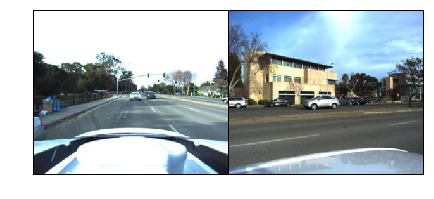

In [16]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [7,7]
plt.imshow(torchvision.utils.make_grid(sample[idx], nrow=3).numpy().transpose(1, 2, 0))
plt.axis('off');

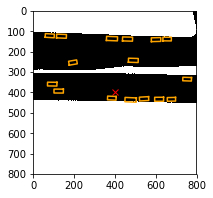

In [17]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [3,3]

fig, ax = plt.subplots()
ax.imshow(road_maps[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
for bb in bbs[idx]:
    draw_box(ax, bb, 'orange')

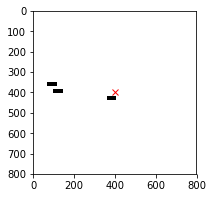

In [18]:
matplotlib.rcParams['figure.figsize'] = [3,3]
fig, ax = plt.subplots()
ax.imshow(bbox_maps[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")

In [19]:
sample[idx][0].shape

torch.Size([3, 256, 306])

In [20]:
back_pred_map = torch.sigmoid(back_vehicle[idx])
left_pred_map = torch.sigmoid(left_vehicle[idx])

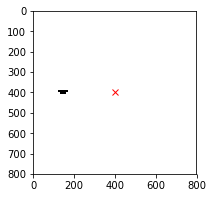

In [21]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [3,3]
threshold = 0.3
reconstruct_back_map = reconstruct_from_bins(back_pred_map, threshold).cpu()
reconstruct_left_map = reconstruct_from_bins(left_pred_map, threshold).cpu()

reconstruct_map = reconstruct_back_map + reconstruct_left_map

fig, ax = plt.subplots()
ax.imshow(reconstruct_map, cmap ='binary');
ax.plot(400, 400, 'x', color="red")

In [22]:
# TODO: Change this to not transpose in the collate_fn and stuff. With the newest model. 
bb_map = reconstruct_map.clone()

def go(direction, top_left, width, height):
    threshold = 0.0
    r, c = top_left
    delta = 5
    if direction == 'right':
        c = c + width 
        # now we're at the top-right coordinate. 
        while c + delta < 800:
            block = bb_map[r:r+height, c:c+delta]
            score = torch.sum(block).item()
            if score > threshold * height * delta:
                c = c + delta
                width = width + delta
            else:
                break
                
        return top_left, width, height
                
    elif direction == 'left':
        # At top-left coordinate. 
        while c - delta > 0:
            block = bb_map[r:r+height, c-delta:c]
            score = torch.sum(block).item()
            if score > threshold * height * delta:
                c = c - delta
                width = width + delta
            else:
                break
        
        return (r, c), width, height
    
    elif direction == 'up':
        # At top_left coordinate. 
        while r - delta > 0:
            block = bb_map[r-delta:r, c:c+width]
            score = torch.sum(block).item()
            if score > threshold * width * delta:
                r = r - delta
                height = height + delta
            else:
                break
        
        return (r, c), width, height
    
    elif direction == 'down':
        r = r + delta
        # At bottom_left coordinate. 
        while r + delta < 800:
            block = bb_map[r:r+delta, c:c+width]
            score = torch.sum(block).item()
            if score > threshold * width * delta:
                r = r + delta
                height = height + delta
            else:
                break
        
        return top_left, width, height
        
        
bboxes = []
for r in range(0, 800, 10):
    for c in range(0, 800, 10):
        
        top_left = (r, c)
        width = HORIZ_BLOCK_SIZE
        height = VERT_BLOCK_SIZE
        
        block = bb_map[r:r+VERT_BLOCK_SIZE, c:c+HORIZ_BLOCK_SIZE]
        score = torch.sum(block).item()
        # If more than have the pixels are 1, classify as bbox car
        if score > (BLOCK_AREA) / 2:
            top_left, width, height = go('right', top_left, width, height)
            top_left, width, height = go('left', top_left, width, height)
            top_left, width, height = go('up', top_left, width, height)
            top_left, width, height = go('down', top_left, width, height)
            
            bboxes.append((top_left, width, height))
            bb_map[top_left[0]:top_left[0] + height, top_left[1]:top_left[1] + width] = 0     

In [23]:
print(len(bboxes))
new_bboxes = []
for x in bboxes:
    _, width, height = x
    if width * height > 300:
        new_bboxes.append(x)
        
bboxes = new_bboxes
print(len(bboxes))

1
1


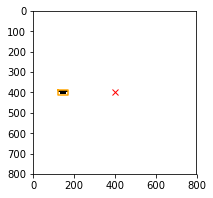

In [24]:
matplotlib.rcParams['figure.figsize'] = [3,3]
threshold = 0.2

fig, ax = plt.subplots()
ax.imshow(reconstruct_map, cmap ='binary');
ax.plot(400, 400, 'x', color="red")
for bb in bboxes:
    draw_vish_box(ax, bb[0], bb[1], bb[2], 'orange')

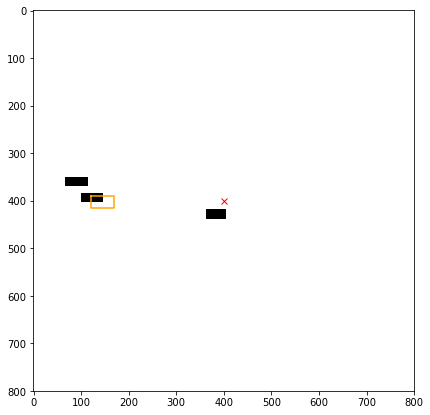

In [25]:
matplotlib.rcParams['figure.figsize'] = [7,7]
fig, ax = plt.subplots()
ax.imshow(bbox_maps[idx], cmap ='binary');
ax.plot(400, 400, 'x', color="red")
for bb in bboxes:
    draw_vish_box(ax, bb[0], bb[1], bb[2], 'orange')

In [26]:
compute_bbox_score(bboxes, bbs, idx, log=True)

NameError: name 'compute_bbox_score' is not defined

In [27]:
def go(direction, top_left, width, height):
    threshold = 0.0
    r, c = top_left
    delta = 10
    if direction == 'right':
        c = c + width 
        # now we're at the top-right coordinate. 
        while c + delta < 800:
            block = bb_map[r:r+height, c:c+delta]
            score = torch.sum(block).item()
            if score > threshold * height * delta:
                c = c + delta
                width = width + delta
            else:
                break
                
        return top_left, width, height
                
    elif direction == 'left':
        # At top-left coordinate. 
        while c - delta > 0:
            block = bb_map[r:r+height, c-delta:c]
            score = torch.sum(block).item()
            if score > threshold * height * delta:
                c = c - delta
                width = width + delta
            else:
                break
        
        return (r, c), width, height
    
    elif direction == 'up':
        # At top_left coordinate. 
        while r - delta > 0:
            block = bb_map[r-delta:r, c:c+width]
            score = torch.sum(block).item()
            if score > threshold * width * delta:
                r = r - delta
                height = height + delta
            else:
                break
        
        return (r, c), width, height
    
    elif direction == 'down':
        r = r + delta
        # At bottom_left coordinate. 
        while r + delta < 800:
            block = bb_map[r:r+delta, c:c+width]
            score = torch.sum(block).item()
            if score > threshold * width * delta:
                r = r + delta
                height = height + delta
            else:
                break
        
        return top_left, width, height

In [28]:
def compute_ats_bounding_boxes(boxes1, boxes2, log=False):
    num_boxes1 = boxes1.size(0)
    num_boxes2 = boxes2.size(0)

    boxes1_max_x = boxes1[:, 0].max(dim=1)[0]
    boxes1_min_x = boxes1[:, 0].min(dim=1)[0]
    boxes1_max_y = boxes1[:, 1].max(dim=1)[0]
    boxes1_min_y = boxes1[:, 1].min(dim=1)[0]

    boxes2_max_x = boxes2[:, 0].max(dim=1)[0]
    boxes2_min_x = boxes2[:, 0].min(dim=1)[0]
    boxes2_max_y = boxes2[:, 1].max(dim=1)[0]
    boxes2_min_y = boxes2[:, 1].min(dim=1)[0]

    condition1_matrix = (boxes1_max_x.unsqueeze(1) > boxes2_min_x.unsqueeze(0))
    condition2_matrix = (boxes1_min_x.unsqueeze(1) < boxes2_max_x.unsqueeze(0))
    condition3_matrix = (boxes1_max_y.unsqueeze(1) > boxes2_min_y.unsqueeze(0))
    condition4_matrix = (boxes1_min_y.unsqueeze(1) < boxes2_max_y.unsqueeze(0))
    condition_matrix = condition1_matrix * condition2_matrix * condition3_matrix * condition4_matrix

    iou_matrix = torch.zeros(num_boxes1, num_boxes2)
    for i in range(num_boxes1):
        for j in range(num_boxes2):
            if condition_matrix[i][j]:
                iou_matrix[i][j] = compute_iou(boxes1[i], boxes2[j])

    iou_max = iou_matrix.max(dim=0)[0]
    if log:
        print(torch.max(iou_max))
    

    iou_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
    total_threat_score = 0
    total_weight = 0
    for threshold in iou_thresholds:
        tp = (iou_max > threshold).sum()
        threat_score = tp * 1.0 / (num_boxes1 + num_boxes2 - tp)
        total_threat_score += 1.0 / threshold * threat_score
        total_weight += 1.0 / threshold

    average_threat_score = total_threat_score / total_weight

    return average_threat_score




def compute_ts_road_map(road_map1, road_map2):
    tp = (road_map1 * road_map2).sum()

    return tp * 1.0 / (road_map1.sum() + road_map2.sum() - tp)

def compute_iou(box1, box2):
    a = Polygon(torch.t(box1)).convex_hull
    b = Polygon(torch.t(box2)).convex_hull

    return a.intersection(b).area / a.union(b).area

In [29]:
def compute_bbox_score(bboxes, bbs, idx = False, log=False):
    bb_samples = []

    bounding_boxes = []
    for bb in bboxes:
        top_left, width, height = bb
        r, c = top_left
        xs = torch.Tensor([c, c+width, c+width, c])
        ys = torch.Tensor([r, r, r+height, r+height])

        xs = xs - 400
        ys = 800 - ys # right-side up
        ys = ys - 400

        xs /= 10.
        ys /= 10.

        coords = torch.stack((xs, ys))
        bounding_boxes.append(coords)

    bounding_boxes = torch.stack(bounding_boxes).double()
    bb_samples.append(bounding_boxes)
    bb_samples = tuple(bb_samples)
    
    if type(idx) == int:
        return compute_ats_bounding_boxes(bb_samples[0].cpu(), torch.stack(bbs[idx]).cpu(), log=True)
    else:
        return compute_ats_bounding_boxes(bb_samples[0].cpu(), torch.stack(bbs[0]).cpu(), log=False)

In [30]:
thresholds = [0.2, 0.25, 0.3, 0.35]
for threshold in thresholds:
    val_loader = torch.utils.data.DataLoader(labeled_valset, batch_size=1, shuffle=True, collate_fn=collate_fn)

    back_model.eval()
    left_model.eval()

    threat_scores = 0
    threats = []

#     print(len(val_loader))

    with torch.no_grad():
        for i, (sample, bbox_bins, road_maps, bbs, counts, bbox_maps) in enumerate(val_loader):
                        
            back_vehicle, back_count = back_model(sample[0][0][:, 125:, :].unsqueeze(0))
            left_vehicle, left_count = left_model(sample[0][1][:, 130:, :].unsqueeze(0))
            
            back_pred_map = torch.sigmoid(back_vehicle[0])
            left_pred_map = torch.sigmoid(left_vehicle[0])
            
            reconstruct_back_map = reconstruct_from_bins(back_pred_map, threshold).cpu()
            reconstruct_left_map = reconstruct_from_bins(left_pred_map, threshold).cpu()

            reconstruct_map = reconstruct_back_map + reconstruct_left_map

            bb_map = reconstruct_map.clone()

            bboxes = []
            for r in range(0, 800, 10):
                for c in range(0, 800, 10):

                    top_left = (r, c)
                    width = VERT_BLOCK_SIZE
                    height = HORIZ_BLOCK_SIZE

                    block = bb_map[r:r+VERT_BLOCK_SIZE, c:c+HORIZ_BLOCK_SIZE]
                    score = torch.sum(block).item()
                    # If more than have the pixels are 1, classify as bbox car
                    if score > (BLOCK_AREA) / 2:
                        top_left, width, height = go('right', top_left, width, height)
                        top_left, width, height = go('left', top_left, width, height)
                        top_left, width, height = go('up', top_left, width, height)
                        top_left, width, height = go('down', top_left, width, height)

                        bboxes.append((top_left, width, height))
                        bb_map[top_left[0]:top_left[0] + height, top_left[1]:top_left[1] + width] = 0    


            new_bboxes = []
            for x in bboxes:
                _, width, height = x
                if width * height > 300:
                    new_bboxes.append(x)

            bboxes = new_bboxes

            if len(bboxes) == 0:
                continue

            ts_bounding_box = compute_bbox_score(bboxes, bbs, log=False)

            threat_scores += ts_bounding_box
            threats.append(ts_bounding_box)

            if i % 30 == 0:
                print("\tAverage Threat Score so far, {}th iteration: {}".format(i, np.mean(threats)))

    print("Threshold {}, Average threat score: {}".format(threshold, threat_scores/len(val_loader)))
            
 

	Average Threat Score so far, 0th iteration: 0.0
	Average Threat Score so far, 30th iteration: 0.0297741387039423
	Average Threat Score so far, 60th iteration: 0.03028872422873974
	Average Threat Score so far, 90th iteration: 0.02876003459095955
	Average Threat Score so far, 120th iteration: 0.03388101980090141
	Average Threat Score so far, 150th iteration: 0.03396586701273918
	Average Threat Score so far, 180th iteration: 0.03248964250087738
	Average Threat Score so far, 210th iteration: 0.03477105498313904
	Average Threat Score so far, 240th iteration: 0.03634309023618698
Threshold 0.2, Average threat score: 0.03622400388121605
	Average Threat Score so far, 0th iteration: 0.022352315485477448
	Average Threat Score so far, 30th iteration: 0.03936924412846565
	Average Threat Score so far, 60th iteration: 0.03619403392076492
	Average Threat Score so far, 90th iteration: 0.036698486655950546
	Average Threat Score so far, 120th iteration: 0.037784744054079056
	Average Threat Score so far,

In [ ]:
# ALl right so I think I have to do 10 by 10, probably. 
# The left one seems fine, the back one not so much. 
# I'll try resnet-34 for the back one, and I'll also try 125. 